In [69]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [454]:
def normalize(x, invert=True):
    x = (x - x.min()) / (x.max() - x.min())
    if invert:
        x = 1 - x
    return x

def to_img(x, invert=True):
    if invert:
        x = 1 - x
    return ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8)

def to_array(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

In [496]:
img = Image.open('roughness-study/rough_1.jpg')
img_clean = Image.open('roughness-study/clean_1.jpg')
w, h = img.size
img = img.resize((w//4, h//4))
img_clean = img_clean.resize((w//4, h//4))

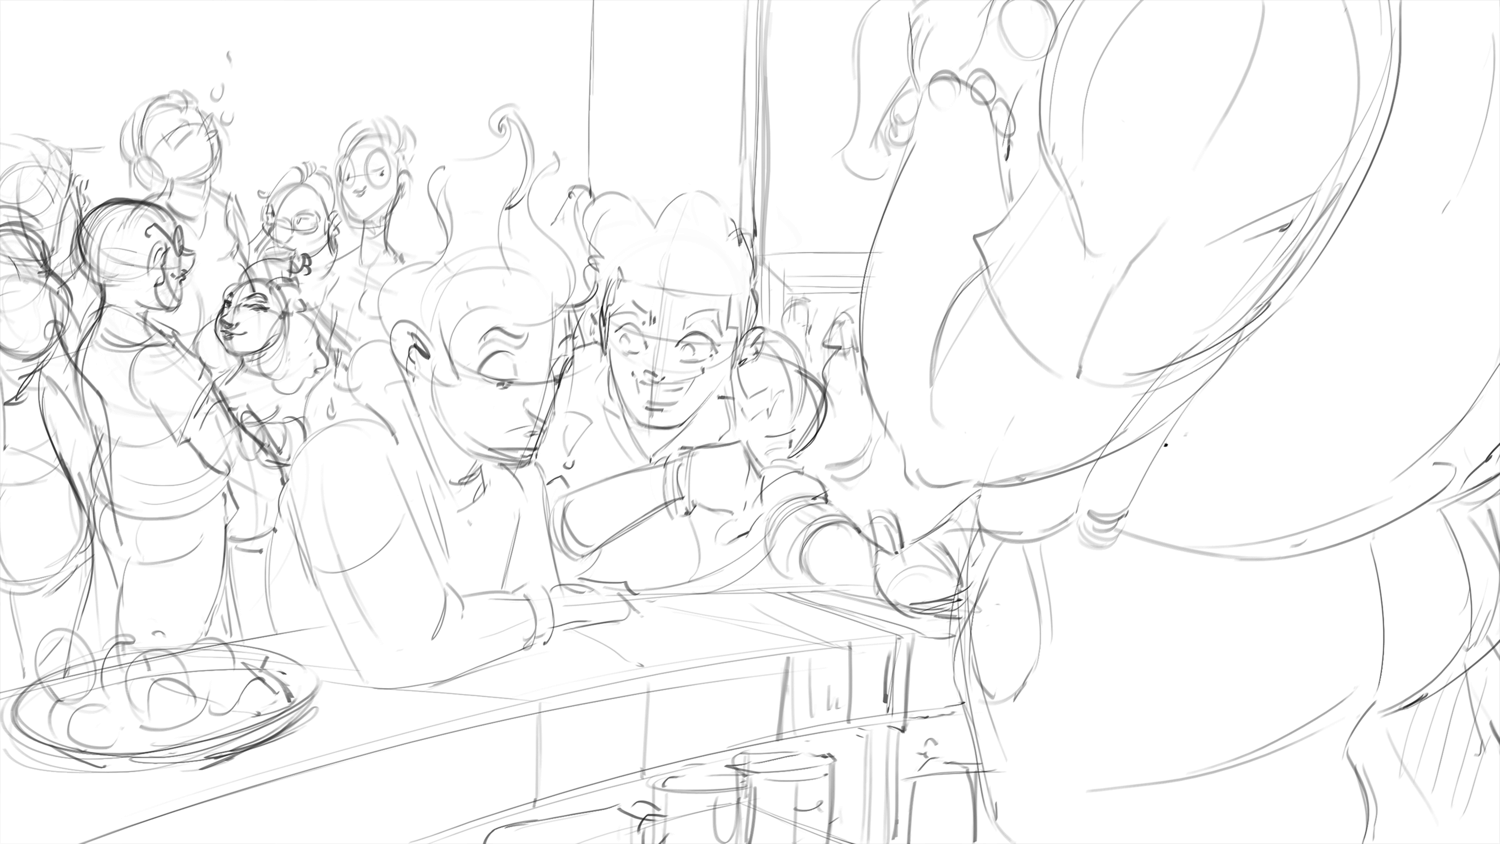

In [497]:
gray = to_array(img)
gray_clean = to_array(img_clean)
# normalize rough sketch so that the maximum line intensity is same as clean sketch
gray = to_img(gray, invert=False)
Image.fromarray(gray)

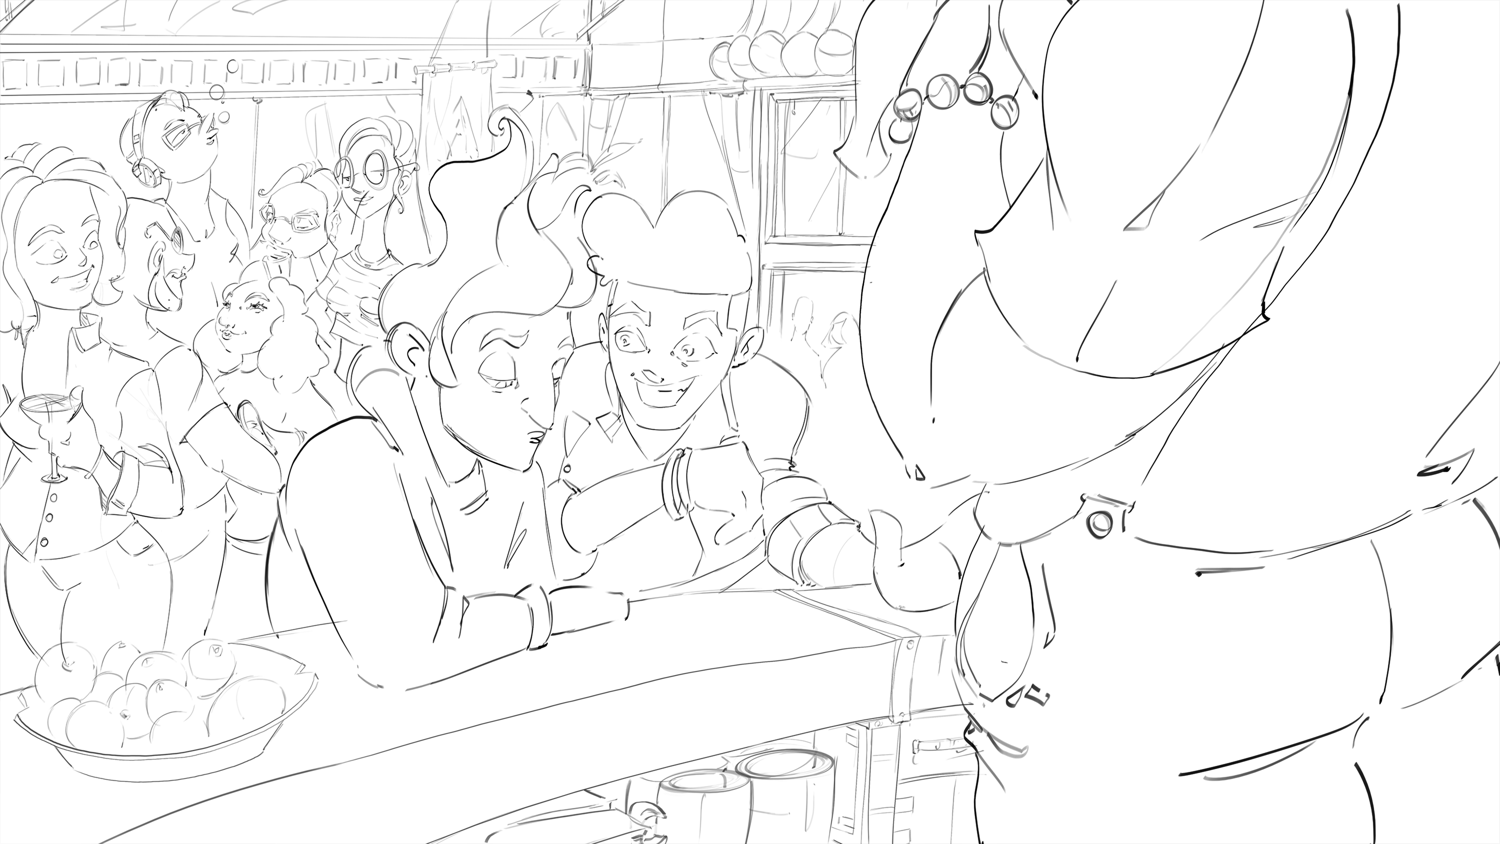

In [12]:
Image.fromarray(gray_clean)

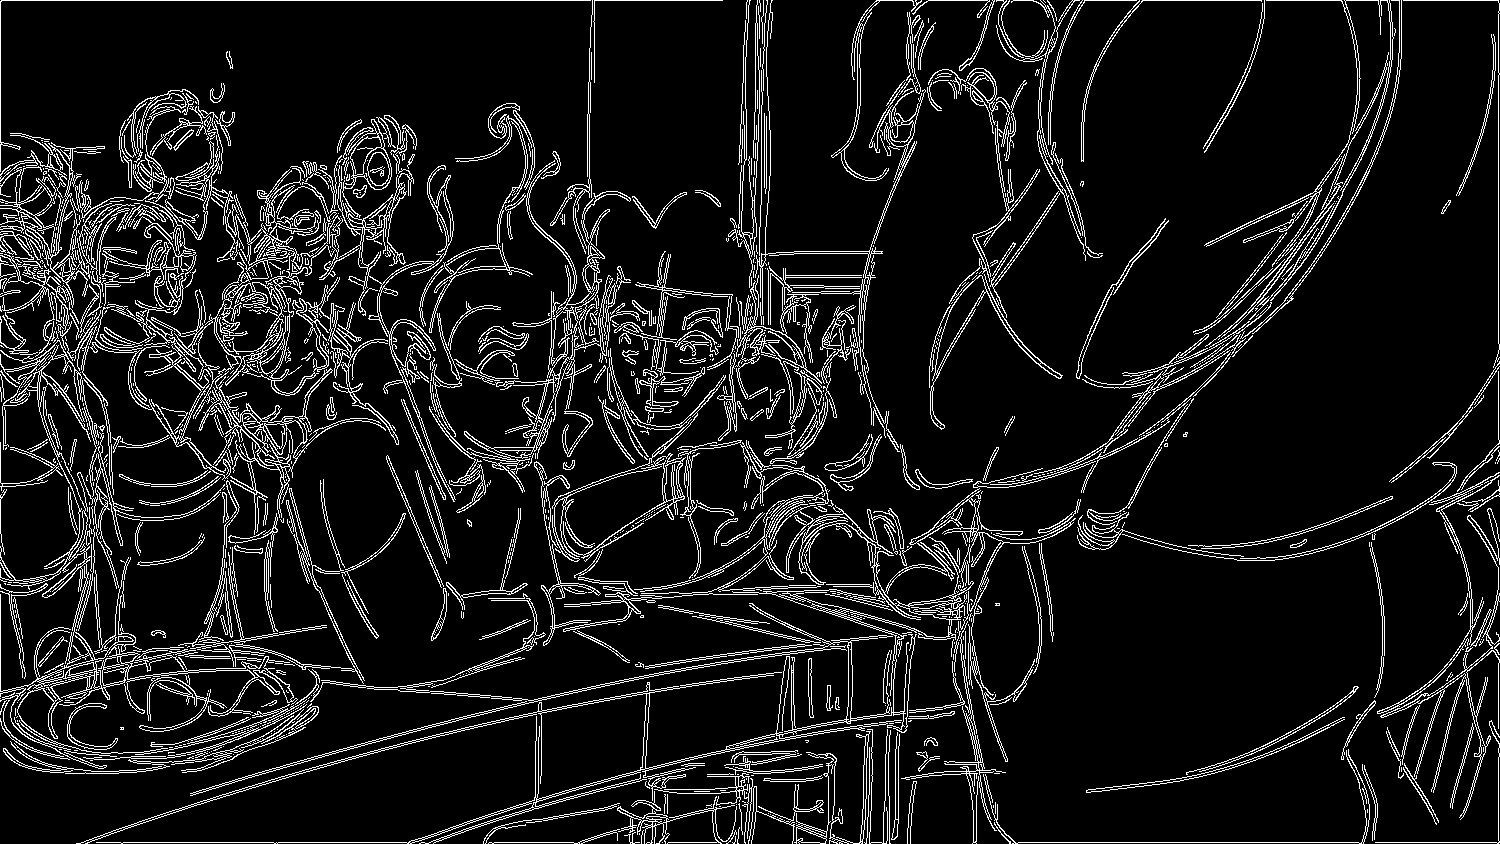

In [10]:
low_threshold = 20
high_threshold = 100
edges = cv2.Canny(gray, low_threshold, high_threshold)
edges_clean = cv2.Canny(gray_clean, low_threshold, high_threshold)
Image.fromarray(edges)

### Goal: Detect frequency of close, parallel lines (indicates roughness) 

In [368]:
kernel_1 = np.array([
    [3, 0, 0],
    [10, 0, 0],
    [3, 0, 0],
])
kernel_2 = np.array([
    [0, 0, 3],
    [0, 0, 10],
    [0, 0, 3],
])
kernel_neg = np.array([
    [0, -3, 0],
    [0, -10, 0],
    [0, -3, 0],
])
def find_parallel(img, penalty=1.0):
    max1 = np.maximum(cv2.filter2D(img, cv2.CV_64F, kernel=kernel_1 + kernel_neg * penalty), 0)
    max2 = np.maximum(cv2.filter2D(img, cv2.CV_64F, kernel=kernel_2 + kernel_neg * penalty), 0)
    return (
        max1 / kernel_1.sum() * max2 / kernel_2.sum(),
        max1,
        max2,
    )

In [461]:
def scale(x, clip_to=0.6):
    x = np.maximum(x, 0)
    return np.minimum((x / clip_to) ** 2, 1.0)

def overlay(img, overlay_arr=None, figsize=(14, 18), ax=None, overlay_color=(255, 0, 0)): # red
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    img = np.stack([img, img, img], axis=2)
    if overlay_arr is not None:
        overlay_arr = cv2.dilate(overlay_arr, kernel=np.ones((3, 3), np.uint8))
        overlay_img = np.zeros_like(img, np.uint8)
        overlay_img[:,:] = np.array(overlay_color)
        img = (img * (1 - overlay_arr)[:,:,None] + overlay_img * overlay_arr[:,:,None]).astype(np.uint8)
    ax.imshow(img)

In [426]:
kernel_size = 3, 3
norm_gray = normalize(gray)
blur_gray = cv2.dilate(norm_gray, kernel=np.ones(kernel_size, np.uint8))
parallel_x, max1, max2 = find_parallel(blur_gray, penalty=1.0)

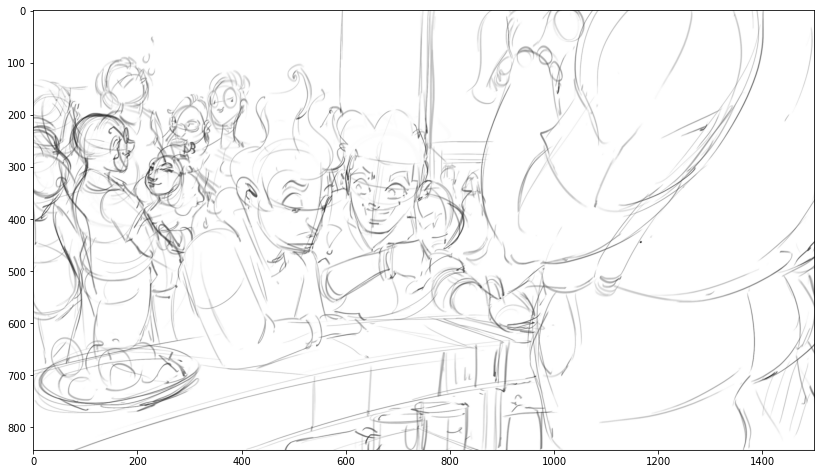

In [427]:
overlay(gray)

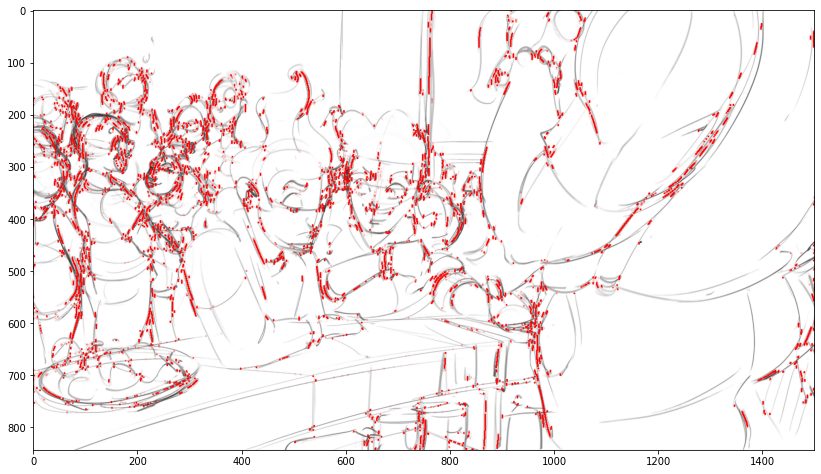

In [435]:
overlay(gray, scale(parallel_x, clip_to=0.001))

In [402]:
kernel_size = 3, 3
norm_gray_clean = normalize(gray_clean)
blur_gray_clean = cv2.dilate(norm_gray_clean, kernel=np.ones(kernel_size, np.uint8))
parallel_x_clean, max1, max2 = find_parallel(blur_gray_clean, penalty=1.0)

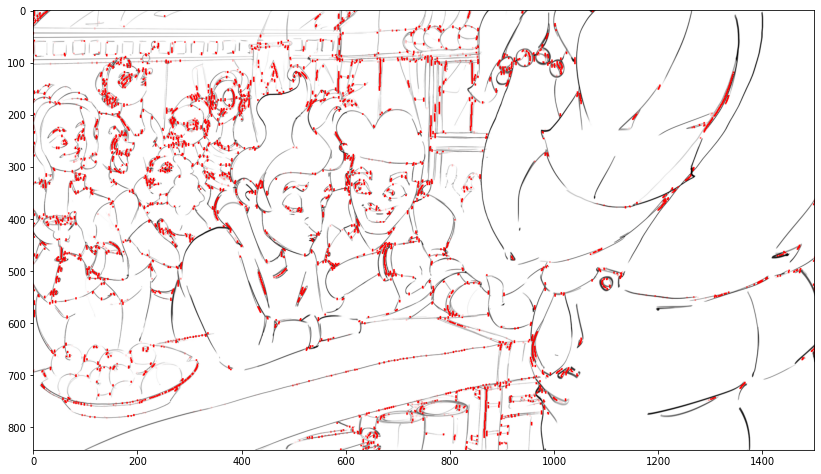

In [436]:
overlay(gray_clean, scale(parallel_x_clean, clip_to=0.001))

(0.0, 1000.0)

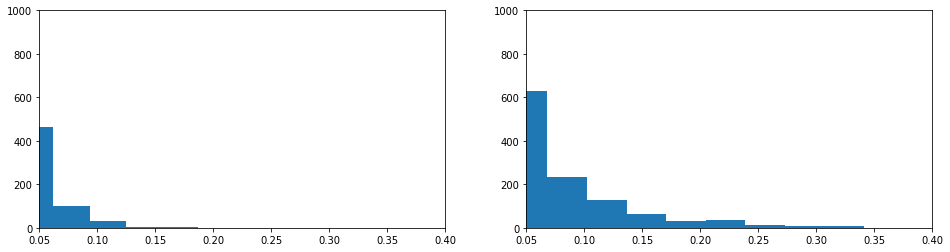

In [429]:
xlim = (0.05, 0.4)
ylim = (0, 1000)
_, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].hist(parallel_x.flatten())
ax[1].hist(parallel_x_clean.flatten())
ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)
ax[1].set_xlim(*xlim)
ax[1].set_ylim(*ylim)

In [434]:
(parallel_x > 0).sum(), (parallel_x_clean > 0).sum()

(23245, 15408)

In [437]:
parallel_x.sum(), parallel_x_clean.sum()

(89.290001261534, 138.90236922097267)

While there are higher value detections in the distribution tail for the clean sketch, there are more detections overall in the rough sketch, with a visibly wider spread

### Detecting parallels across multiple scales

In [438]:
def parallel_from_img(img, kernel_size=(3, 3)):
    norm_gray_clean = normalize(img)
    return find_parallel(norm_gray_clean, penalty=1.0)

In [485]:
arr[0,0]

255

In [488]:
arr

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 244, 250, ..., 255, 255, 255],
       [255, 246, 247, ..., 255, 255, 255],
       [255, 249, 244, ..., 255, 255, 255]], dtype=uint8)

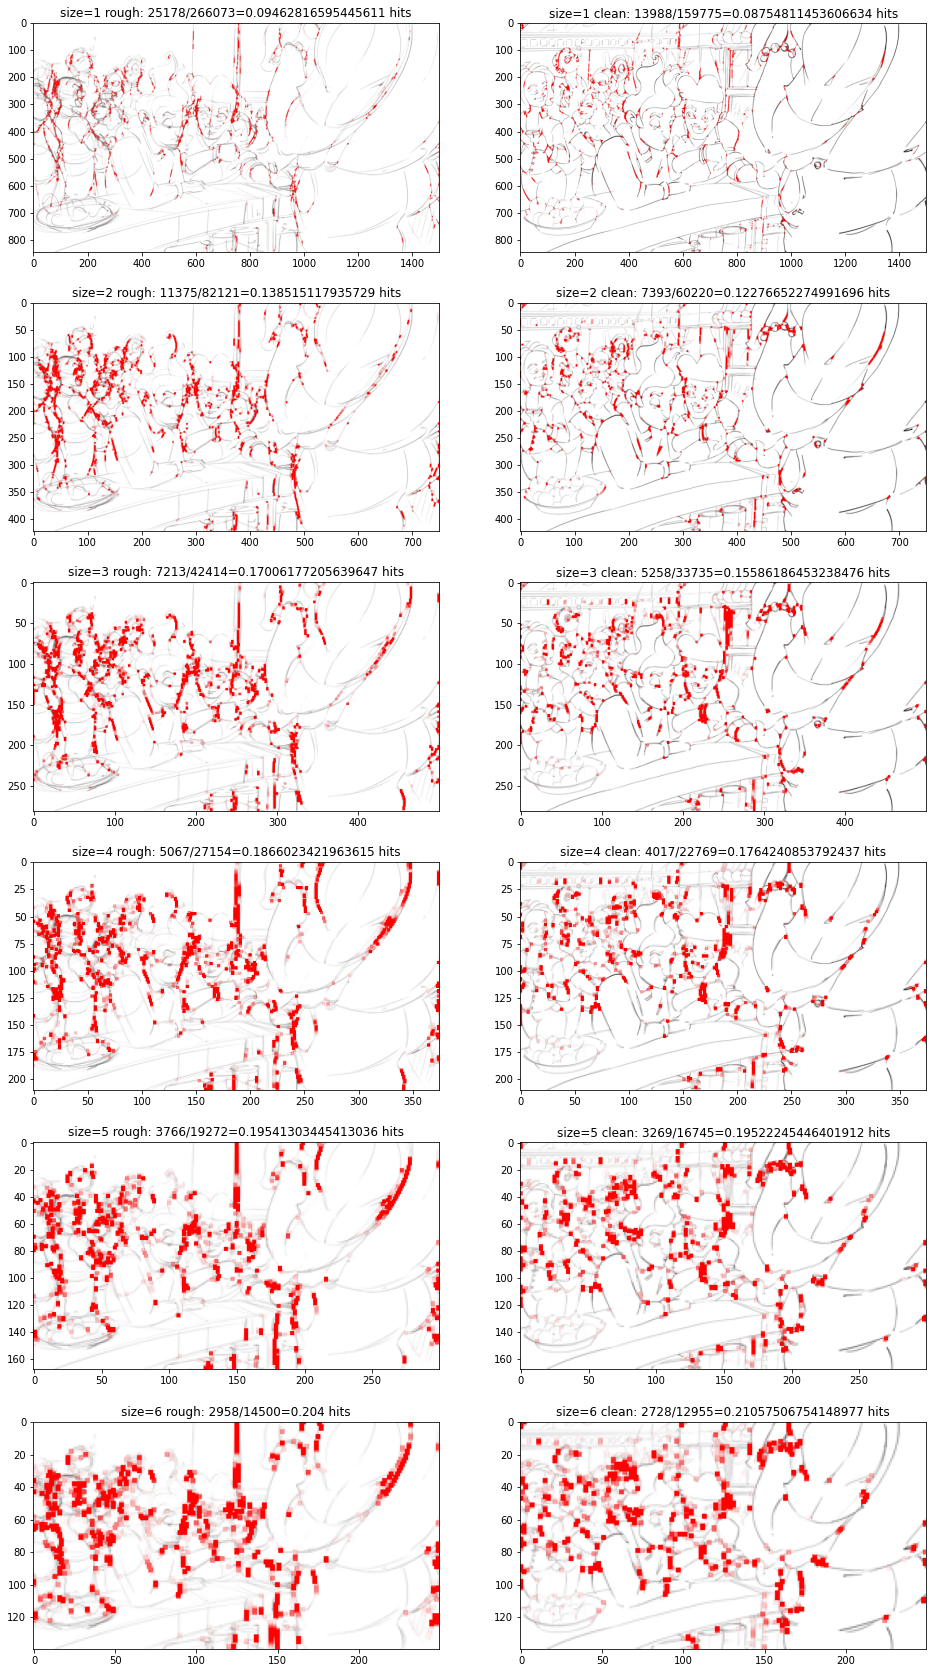

In [501]:
sizes = [1, 2, 3, 4, 5, 6]
w, h = img.size

fig, ax = plt.subplots(len(sizes), 2, figsize=(16, 5*len(sizes)))

for i, size in enumerate(sizes):
    resized = img.resize((w // size, h // size))
    resized_clean = img_clean.resize((w // size, h // size))
    arr = to_array(resized)
    arr_clean = to_array(resized_clean)
    parallel_x, _, _ = parallel_from_img(arr)
    parallel_x_clean, _, _, = parallel_from_img(arr_clean)
    overlay(arr, scale(parallel_x, clip_to=0.01), ax=ax[i, 0])
    overlay(arr_clean, scale(parallel_x_clean, clip_to=0.01), ax=ax[i, 1])
    ax[i, 0].set_title(f"size={size} rough: {(parallel_x > 0).sum()}/{(arr < 255).sum()}={(parallel_x > 0).sum()/(arr < 255).sum()} hits")
    ax[i, 1].set_title(f"size={size} clean: {(parallel_x_clean > 0).sum()}/{(arr_clean < 255).sum()}={(parallel_x_clean > 0).sum()/(arr_clean < 255).sum()} hits")

In [504]:
img = Image.open('roughness-study/loose_2.jpg')
img_clean = Image.open('roughness-study/rough_2.jpg')
w, h = img.size
img = img.resize((w//2, h//2))
img_clean = img_clean.resize((w//2, h//2))

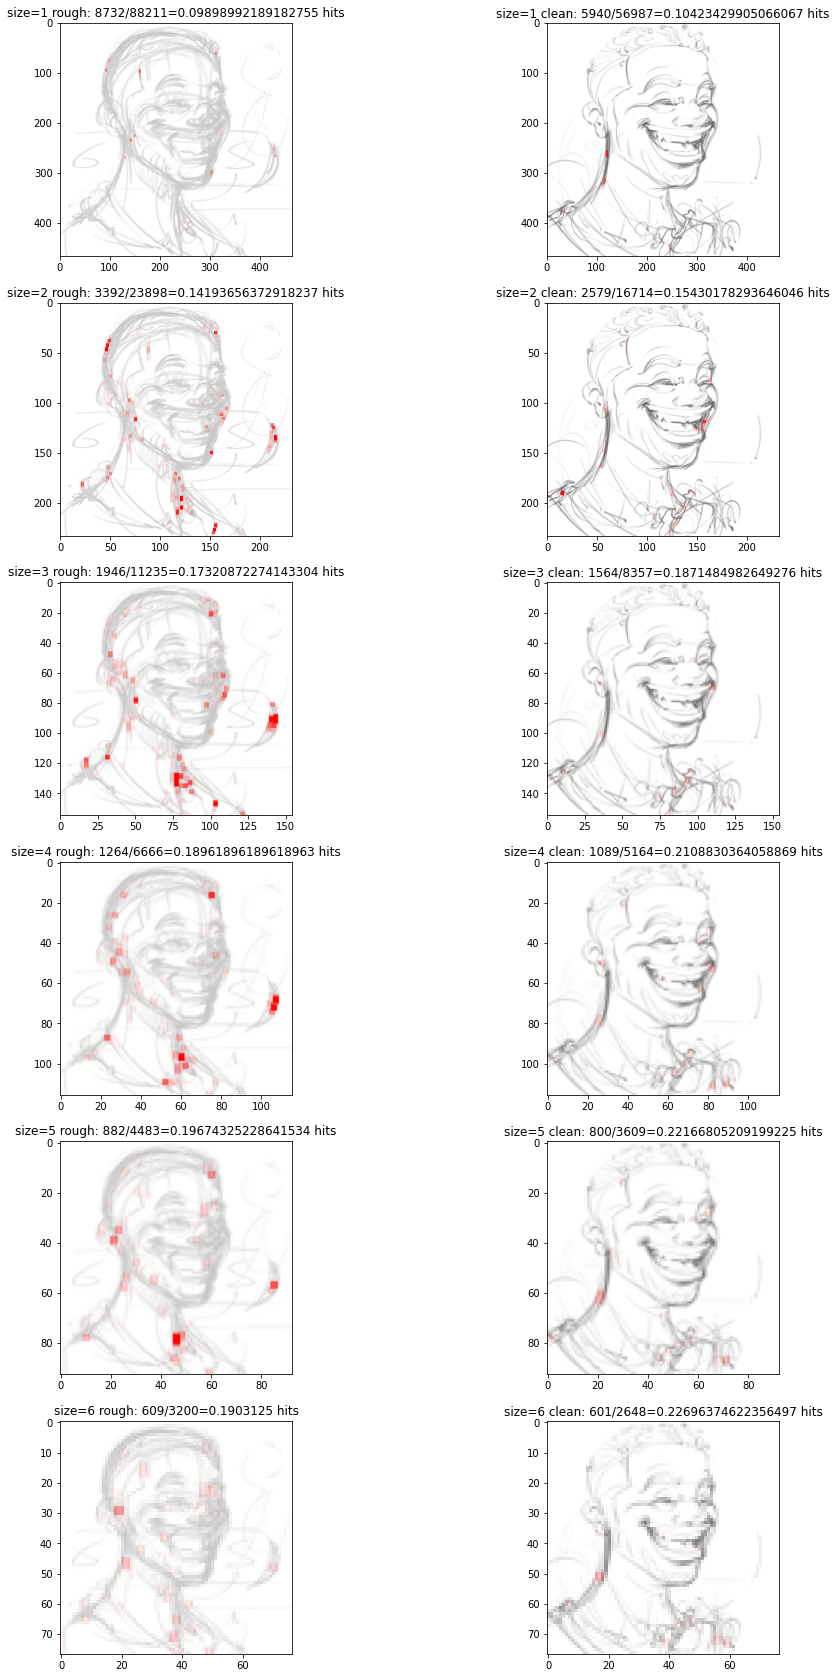

In [507]:
sizes = [1, 2, 3, 4, 5, 6]
w, h = img.size
clip_to = 0.2

fig, ax = plt.subplots(len(sizes), 2, figsize=(16, 5*len(sizes)))

for i, size in enumerate(sizes):
    resized = img.resize((w // size, h // size))
    resized_clean = img_clean.resize((w // size, h // size))
    arr = to_array(resized)
    arr_clean = to_array(resized_clean)
    parallel_x, _, _ = parallel_from_img(arr)
    parallel_x_clean, _, _, = parallel_from_img(arr_clean)
    overlay(arr, scale(parallel_x, clip_to=clip_to), ax=ax[i, 0])
    overlay(arr_clean, scale(parallel_x_clean, clip_to=clip_to), ax=ax[i, 1])
    ax[i, 0].set_title(f"size={size} rough: {(parallel_x > 0).sum()}/{(arr < 255).sum()}={(parallel_x > 0).sum()/(arr < 255).sum()} hits")
    ax[i, 1].set_title(f"size={size} clean: {(parallel_x_clean > 0).sum()}/{(arr_clean < 255).sum()}={(parallel_x_clean > 0).sum()/(arr_clean < 255).sum()} hits")

Gap in detection count between clean and rough sketches decreases with scale. Spread of detections seems to be a solid indicator